<a href="https://colab.research.google.com/github/Andreani24/Alignment-assetment-/blob/main/Binary_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Find the image
from google.colab import files
uploaded = files.upload()

Saving microscope2.jpg to microscope2 (1).jpg


In [3]:
# ==================================
#       1. Environment Setup
# ==================================

# Check for and display GPU information. This is crucial for performance with SAM.
!nvidia-smi

# Get the current working directory to create paths relative to the notebook.
import os
HOME = os.getcwd()

# Install required libraries.
# `segment-anything` is the core library for the SAM model.
# `jupyter_bbox_widget` is for bounding box annotations (though not used in this specific script).
# `roboflow` and `dataclasses-json` are likely for dataset handling or metadata.
# `supervision` is a computer vision utility library used for annotations and detections.
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

Thu Aug 21 10:26:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/content/weights/sam_vit_b_01ec64.pth ; exist: True


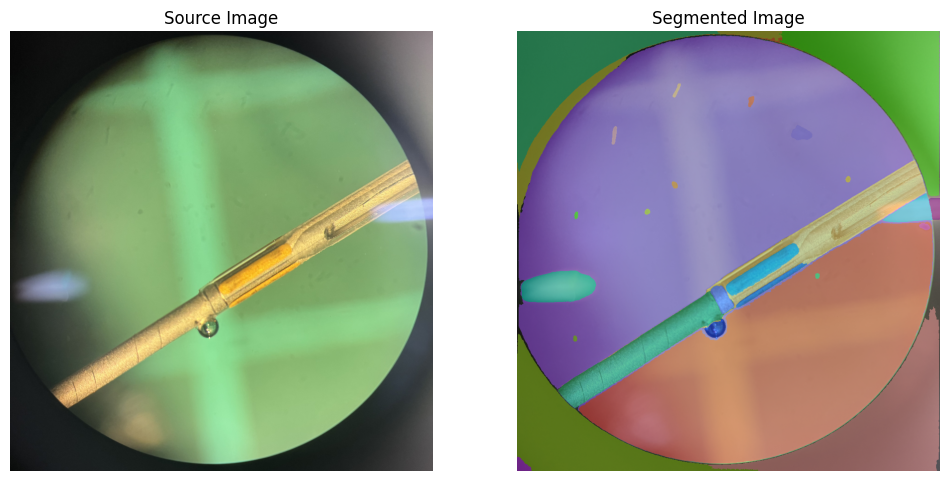

In [31]:

# ==================================
#       2. Data and Model Download
# ==================================

# Create a directory to store the model weights.
!mkdir -p {HOME}/weights

# Download the pre-trained SAM model checkpoint.
# `sam_vit_h_4b8939.pth` is the largest and most accurate model (`vit_h`).
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P {HOME}/weights

# Set the path to the downloaded model checkpoint and verify it exists.
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_b_01ec64.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


# Obtain image
IMAGE_PATH = r"microscope2.jpg"

# ==================================
#       3. Model Initialization
# ==================================

# Import necessary libraries for model loading.
import torch
import cv2
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Set the device for computation. It will use a CUDA-enabled GPU if available,
# otherwise it will fall back to the CPU (which is much slower).
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

# Load the Segment Anything Model (SAM) with the specified checkpoint and device.
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# Initialize the automatic mask generator. This is the main component that
# will generate segmentation masks for the entire image without any prompts.
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64, # Increase this value for more masks
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=50000
)

# ==================================
#       4. Image Processing and Segmentation
# ==================================

# Read the image using OpenCV.
image_bgr = cv2.imread(IMAGE_PATH)

# Convert the image from BGR (OpenCV's default) to RGB, as SAM expects RGB input.
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Resize the image to a smaller resolution
max_dimension = 1024
height, width, _ = image_rgb.shape
if max(height, width) > max_dimension:
    scale = max_dimension / max(height, width)
    new_size = (int(width * scale), int(height * scale))
    image_rgb_resized = cv2.resize(image_rgb, new_size, interpolation=cv2.INTER_AREA)
else:
    image_rgb_resized = image_rgb

# Now, generate masks with the resized image
sam_result = mask_generator.generate(image_rgb_resized)

# Initialize the annotator from the `supervision` library.
# It will use a unique color for each segmented mask.
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert the SAM results into `supervision.Detections` format.
# This structure is needed for easy annotation.
detections = sv.Detections.from_sam(sam_result=sam_result)

# Annotate the original image with the generated masks.
annotated_image = mask_annotator.annotate(scene=image_rgb_resized.copy(), detections=detections)

# ==================================
#       5. Visualization
# ==================================

# Display the original and the segmented image side by side using `supervision`.
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['Source Image', 'Segmented Image']
)


In [60]:
# This code section filters the masks according to their circularity to remove non-cirular objects
# Define a circularity threshold range.
lower_bound = 0.1
upper_bound = 0.5

# List to hold the filtered masks
filtered_sam_result = []

for mask_data in sam_result:
    mask = mask_data['segmentation']

    # ... (rest of your existing code to calculate circularity) ...
    mask_uint8 = mask.astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter > 0:
            circularity = 4 * math.pi * area / (perimeter * perimeter)

            # Use 'and' to check if the circularity is between the two bounds.
            if lower_bound <= circularity <= upper_bound:
                filtered_sam_result.append(mask_data)

# Use 'filtered_sam_result' for all subsequent operations
detections = sv.Detections.from_sam(sam_result=filtered_sam_result)

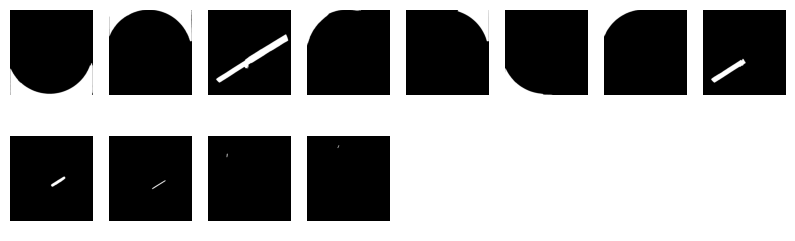

In [61]:
import math
masks = [
    mask['segmentation']
    for mask
    in sorted(filtered_sam_result, key=lambda x: x['area'], reverse=True)
]

# Calculate the number of rows and columns
num_masks = len(masks)
n_cols = 8  # Fixed number of columns for a clean look
n_rows = math.ceil(num_masks / n_cols)  # Calculate rows, rounding up

sv.plot_images_grid(
    images=masks,
    grid_size=(n_rows, n_cols),
    size=(10, 3)
)
